In [1]:
# Import Transformer Lens, and load pythia models
from transformer_lens import HookedTransformer
import torch as th
from datasets import load_dataset
# from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm
from einops import rearrange
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained("EleutherAI/pythia-160m-deduped", device=device)

# tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-160m-deduped")
seq_length = 20

# Load the training set from pile-10k
d = load_dataset("NeelNanda/pile-10k", split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > seq_length
).map(
    lambda x: {'input_ids': x['input_ids'][:seq_length]}
)

neurons = model.W_in.shape[-1]
dataset_size = d.num_rows
batch_size = 64
layer = 6

neuron_activations = th.zeros((dataset_size*seq_length, neurons))
with th.no_grad(), d.formatted_as("pt"):
    dl = DataLoader(d["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        _, cache = model.run_with_cache(batch.to(device))
        neuron_activations[i*batch_size*seq_length:(i+1)*batch_size*seq_length,:] = rearrange(cache[f"blocks.{layer}.mlp.hook_pre"], "b s n -> (b s) n" )

c:\Users\logan\miniconda3\envs\max\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-160m-deduped into HookedTransformer


Using custom data configuration NeelNanda--pile-10k-72f566e9f7c464ab
Found cached dataset parquet (C:/Users/logan/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 156/156 [06:43<00:00,  2.59s/it]


In [3]:
# Find seq_token with highest activation 
import numpy as np
dataset_by_seq, neurons = neuron_activations.shape
dataset_size = dataset_by_seq//seq_length
np.unravel_index(neuron_activations.argmax(), (dataset_size, seq_length, neurons))

(9521, 15, 493)

In [4]:
# Get stats for each tok_position
for x in range(seq_length):
    mean = neuron_activations.flatten()[x::seq_length].mean()
    min = neuron_activations.flatten()[x::seq_length].min()
    max = neuron_activations.flatten()[x::seq_length].max()
    print(f"Position {x}: Mean: {mean}, Min: {min}, Max: {max}")

Position 0: Mean: -0.499051034450531, Min: -6.071619033813477, Max: 4.830296993255615
Position 1: Mean: -0.4859250485897064, Min: -7.159372806549072, Max: 5.430814266204834
Position 2: Mean: -0.49540963768959045, Min: -7.661962509155273, Max: 4.762789249420166
Position 3: Mean: -0.5272964835166931, Min: -7.525088310241699, Max: 4.764954566955566
Position 4: Mean: -0.4959178864955902, Min: -6.7089104652404785, Max: 4.307471752166748
Position 5: Mean: -0.48519620299339294, Min: -8.718271255493164, Max: 5.639570236206055
Position 6: Mean: -0.4954654574394226, Min: -7.679287910461426, Max: 5.277312278747559
Position 7: Mean: -0.5246610641479492, Min: -8.152499198913574, Max: 4.668896675109863
Position 8: Mean: -0.49278998374938965, Min: -6.23680305480957, Max: 4.238410949707031
Position 9: Mean: -0.48235782980918884, Min: -6.74600887298584, Max: 5.523262977600098
Position 10: Mean: -0.4952610731124878, Min: -6.721911430358887, Max: 4.31566047668457
Position 11: Mean: -0.5286012887954712, M

In [11]:
# Above but for a selection of neurons:
# Get stats for each tok_position
for n in range(10):
    print(f"Neuron {n}:")
    for x in range(seq_length):
        mean = neuron_activations[x::seq_length, n].mean()
        min = neuron_activations[x::seq_length, n].min()
        max = neuron_activations[x::seq_length, n].max()
        print(f"Position {x}: Mean: {mean}, Min: {min}, Max: {max}")

Neuron 0:
Position 0: Mean: -0.1202232837677002, Min: -1.4457429647445679, Max: 0.08812510967254639
Position 1: Mean: -0.24831442534923553, Min: -2.0782241821289062, Max: 1.1115349531173706
Position 2: Mean: -0.13909278810024261, Min: -2.0851523876190186, Max: 1.246303677558899
Position 3: Mean: -0.21961958706378937, Min: -2.191279649734497, Max: 1.4665783643722534
Position 4: Mean: -0.10869306325912476, Min: -2.0780587196350098, Max: 1.419012188911438
Position 5: Mean: -0.13303080201148987, Min: -2.357419013977051, Max: 1.4249504804611206
Position 6: Mean: -0.12489400804042816, Min: -2.2852039337158203, Max: 1.5722671747207642
Position 7: Mean: -0.11565975099802017, Min: -2.350102424621582, Max: 1.3819600343704224
Position 8: Mean: -0.1186814159154892, Min: -2.22318434715271, Max: 1.5856549739837646
Position 9: Mean: -0.09994452446699142, Min: -2.204756498336792, Max: 1.5275300741195679
Position 10: Mean: -0.10372550785541534, Min: -2.1704814434051514, Max: 1.424797773361206
Position 

(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 5.0000e+00, 8.0000e+00,
        4.0000e+00, 1.0000e+01, 8.0000e+00, 1.4000e+01, 2.6000e+01,
        2.0000e+01, 2.4000e+01, 1.7000e+01, 4.6000e+01, 3.4000e+01,
        4.3000e+01, 6.9000e+01, 7.9000e+01, 9.6000e+01, 1.4100e+02,
        1.5200e+02, 1.7400e+02, 2.0400e+02, 2.0500e+02, 2.2700e+02,
        2.7100e+02, 3.8500e+02, 3.7700e+02, 4.4200e+02, 5.6100e+02,
        6.1700e+02, 6.7800e+02, 8.2500e+02, 9.8200e+02, 1.1620e+03,
        1.2650e+03, 1.4290e+03, 1.6580e+03, 1.7610e+03, 1.9870e+03,
        2.2280e+03, 4.0290e+03, 2.9270e+03, 4.5300e+03, 3.4630e+03,
        3.7480e+03, 4.0150e+03, 4.2690e+03, 4.8690e+03, 5.2820e+03,
        5.3820e+03, 5.8450e+03, 1.3685e+04, 6.2030e+03, 1.0078e+04,
        1.2630e+04, 7.0200e+03, 6.9240e+03, 6.7350e+03, 6.7690e+03,
        6.6170e+03, 6.5270e+03, 5.9740e+03, 5.4390e+03, 5.3080e+03,
        4.6990e+03, 4.5650e+03, 3.8130e+03, 3.40

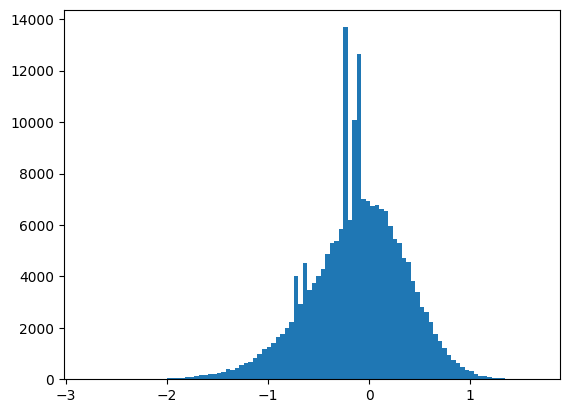

In [10]:
# Plot one neurons distribution of activations
# Maybe skip every Nth activation to speed up
N = 1
import matplotlib.pyplot as plt
neuron = 0
plt.hist(neuron_activations[::N,neuron], bins=100)